## Imports

In [2]:
import csv
import os
import random
import zipfile

from pathlib import Path 
from functools import partial
from typing import Callable, Any,List

import numpy as np 
import torch

from tqdm.notebook import tqdm
from data import get_challenge_points
from metrics import get_tpr_at_fpr

In [3]:
import json

from midst_models.single_table_TabDDPM.wb_complex_pipeline import (
    clava_clustering,
    clava_training,
    clava_load_pretrained,
    clava_synthesizing,
    load_configs,
)
from midst_models.single_table_TabDDPM.wb_pipeline_modules import load_multi_table
from midst_models.single_table_TabDDPM.tab_ddpm.gaussian_multinomial_diffsuion import GaussianMultinomialDiffusion

In [4]:
TABDDPM_DATA_DIR = "tabddpm_white_box"
TABSYN_DATA_DIR = "tabsyn_white_box"

## Loading the Model

In [5]:
# Load config
config_path = "/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1/trans.json"
configs, save_dir = load_configs(config_path)

# Display config
json_str = json.dumps(configs, indent=4)
print(json_str)

{
    "general": {
        "data_dir": "/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1",
        "exp_name": "",
        "workspace_dir": "/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1",
        "sample_prefix": "",
        "test_data_dir": "/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1"
    },
    "clustering": {
        "parent_scale": 1.0,
        "num_clusters": 50,
        "clustering_method": "both"
    },
    "diffusion": {
        "d_layers": [
            512,
            1024,
            1024,
            1024,
            1024,
            512
        ],
        "dropout": 0.0,
        "num_timesteps": 2000,
        "model_type": "mlp",
        "iterations": 200000,
        "batch_size": 4096,
        "lr": 0.0006,
        "gaussian_loss_type": "mse",
        "weight_decay": 1e-05,
        "scheduler": "cosine"
    },
    "classifier": {
        "d_layers": [


In [6]:
configs

{'general': {'data_dir': '/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1',
  'exp_name': '',
  'workspace_dir': '/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1',
  'sample_prefix': '',
  'test_data_dir': '/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1'},
 'clustering': {'parent_scale': 1.0,
  'num_clusters': 50,
  'clustering_method': 'both'},
 'diffusion': {'d_layers': [512, 1024, 1024, 1024, 1024, 512],
  'dropout': 0.0,
  'num_timesteps': 2000,
  'model_type': 'mlp',
  'iterations': 200000,
  'batch_size': 4096,
  'lr': 0.0006,
  'gaussian_loss_type': 'mse',
  'weight_decay': 1e-05,
  'scheduler': 'cosine'},
 'classifier': {'d_layers': [128, 256, 512, 1024, 512, 256, 128],
  'lr': 0.0001,
  'dim_t': 128,
  'batch_size': 4096,
  'iterations': 20000},
 'sampling': {'batch_size': 20000, 'classifier_scale': 1.0},
 'matching': {'num_matching_clusters': 1,
  'matching_batch_si

In [7]:
save_dir

'/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1/'

In [8]:
relation_order = [[None,'trans']]
models = clava_load_pretrained(relation_order,save_dir)

None -> trans checkpoint found, loading...


/home/vidit/.cache/pypoetry/virtualenvs/midst-models-qGUjvEOx-py3.9/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/vidit/.cache/pypoetry/virtualenvs/midst-models-qGUjvEOx-py3.9/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator QuantileTransformer from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [9]:
model = models[None,'trans']['diffusion']

In [10]:
device = "cuda"

In [11]:
model.to(device)

GaussianMultinomialDiffusion(
  (_denoise_fn): MLPDiffusion(
    (mlp): MLP(
      (blocks): ModuleList(
        (0): Block(
          (linear): Linear(in_features=128, out_features=512, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (1): Block(
          (linear): Linear(in_features=512, out_features=1024, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (2): Block(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (3): Block(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (4): Block(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (activation): ReLU()
          (dropout): Dro

## Creating funcitons for GSA

### writing code to implement gsa model
#### Notes
- Can we augment gsa1 with pca so we reduce the dimensionality of the gradients so that we dont have to compromise with the accuracy as well as compute?
- 

In [12]:
tabddpm = model

In [13]:
def gsa1_attack(
    model: GaussianMultinomialDiffusion, 
    x0: torch.Tensor, 
    num_timesteps: int = 10
)-> List[float]:
    
    model.eval()
    timesteps = torch.linspace(0, model.num_timesteps-1, num_timesteps).long()
    losses = []
    
    # Compute losses at sampled timesteps
    for t in timesteps:
        #xt, epsilon = forward_diffusion(x0, t, model)
        x_t = model.gaussian_q_sample(x_start=x0, t=torch.tensor([t]))
        #loss = compute_loss(model, xt, t, epsilon)
        loss = (model.mixed_loss(x_t,{}))
        loss = loss[1]
        #loss.backward()
        losses.append(loss)
    
    # Average losses and compute gradients
    #print(torch.stack(losses))
    avg_loss = torch.mean(torch.stack(losses))
    model.zero_grad()
    #print(avg_loss)
    avg_loss.backward()
    
    # Aggregate gradients (L2 norm per layer)
    gradients = [param.grad.detach().norm().item() for param in model.parameters()]
    return gradients

In [56]:
# this is just a code you wrote to check the denoising output of the tabddpm model; remove it later

# x1 = torch.tensor([1605,2,4,3900.0,41832.1,1,0,0]).to(device)
# x2 = torch.tensor([2006,2,4,14.6,13224.4,6,0,0]).to(device)
# x = torch.stack((x1,x2)).to(device)
# xt = tabddpm.gaussian_q_sample(x_start = x, t = torch.tensor([1995]).to(device))
# print(xt)
# y= {'y': 0}
# losses = tabddpm.mixed_loss(x,y)

tensor([[  6.2141,  -0.2007,   2.1894,  10.5883, 129.3512,   1.0612,  -0.3717,
           1.7467],
        [  5.6716,   1.3297,   0.5305,   0.2330,  40.2541,   0.1729,  -0.7987,
           1.8513]], device='cuda:0')


In [14]:
tabddpm.num_numerical_features

8

In [101]:
# this is extension of above bs code

x1 = torch.tensor([1605,2,4,3900.0,41832.1,1,0,0]).to(device)
x2 = torch.tensor([2006,2,4,14.6,13224.4,6,0,0]).to(device)
x = torch.tensor([[1605,2,4,3900.0,41832.1,1,0,0],[2006,2,4,14.6,13224.4,6,0,0]]).to(device)
out_dict = {}
losses = tabddpm.mixed_loss(x,out_dict)
print(losses)

(tensor(0.), tensor(3.2467e+08, device='cuda:0', grad_fn=<MeanBackward0>))


In [92]:
tabddpm._denoise_fn

MLPDiffusion(
  (mlp): MLP(
    (blocks): ModuleList(
      (0): Block(
        (linear): Linear(in_features=128, out_features=512, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (1): Block(
        (linear): Linear(in_features=512, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (2): Block(
        (linear): Linear(in_features=1024, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (3): Block(
        (linear): Linear(in_features=1024, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (4): Block(
        (linear): Linear(in_features=1024, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (5): Block(
        (linear): Linear(in_features=1024, out

In [111]:
def gsa2_attack(
    model: GaussianMultinomialDiffusion, 
    x0: torch.Tensor, 
    num_timesteps: int = 10
) -> List[float]:
    model.eval()
    timesteps = torch.linspace(0, model.T-1, num_timesteps).long()
    gradients_accum = None
    
    for t in timesteps:
        xt, epsilon = model.gaussian_q_sample(x0, t, model)
        loss = model.mixed_loss(xt,{})
        
        # Compute gradients for this timestep
        model.zero_grad()
        loss.backward()
        current_gradients = [param.grad.detach().clone() for param in model.parameters()]
        
        # Accumulate gradients
        if gradients_accum is None:
            gradients_accum = current_gradients
        else:
            gradients_accum = [g_prev + g_curr for g_prev, g_curr in zip(gradients_accum, current_gradients)]
    
    # Average gradients across timesteps
    averaged_gradients = [g / num_timesteps for g in gradients_accum]
    
    # Aggregate gradients (L2 norm per layer)
    aggregated = [g.norm().item() for g in averaged_gradients]
    return aggregated

In [16]:
# Load a pre-trained diffusion model (example)
x0 = torch.tensor([[1065,2,4,11300.0,34443.0,1,0,0]]).to(device) # Example input (trian_with_id row)

# Extract features using GSA1 and GSA2
gsa1_features = gsa1_attack(model, x0, num_timesteps=10)
#gsa2_features = gsa2_attack(model, x0, num_timesteps=10)

print("GSA1 Features:", gsa1_features)
#print("GSA2 Features:", gsa2_features)


GSA1 Features: [817752704.0, 17535.779296875, 972909120.0, 5185.83447265625, 689796416.0, 1770.6556396484375, 407362784.0, 889.1004028320312, 370952096.0, 856.741455078125, 535143520.0, 1478.76953125, 1664236672.0, 6994.2783203125, 1507248256.0, 62719.77734375, 228478.921875, 42775.609375, 245573.875, 62719.77734375]


In [155]:
import pandas as pd
import torch
from tqdm import tqdm  # Import tqdm for progress tracking

def load_csv_as_tensor(file_path, nrows=None):
    df = pd.read_csv(file_path, header=None, nrows=nrows)  # Read without headers
    df = df.iloc[1:, 2:]  # Drop first two columns
    df = df.apply(pd.to_numeric, errors='coerce')  # Convert all values to numeric
    df = df.fillna(0)  # Replace NaNs with 0 (or use another strategy)
    return torch.tensor(df.values, dtype=torch.float32)  # Convert to tensor

# Load and process the first CSV file
file1 = "/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1/train_with_id.csv"
tensor1 = load_csv_as_tensor(file1)

# Load and process the second CSV file (only first 20,000 rows)
file2 = "/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1/holdout_with_id.csv"  
tensor2 = load_csv_as_tensor(file2, nrows=20000)

final_tensor = torch.cat((tensor1, tensor2), dim=0).to(device='cuda')

train_tensor = []

# Loop over all rows with tqdm progress bar
for row in tqdm(final_tensor, desc="Processing Rows", unit="row"):
    row = row.unsqueeze(0)
    gsa1_features = gsa1_attack(model, row, num_timesteps=10)
    train_tensor.append(gsa1_features)

Processing Rows:   0%|          | 2/39999 [00:02<9:40:35,  1.15row/s] 

tensor(8.1360e+13, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.5448e+08, device='cuda:0', grad_fn=<MeanBackward0>)


Processing Rows:   0%|          | 4/39999 [00:02<4:16:49,  2.60row/s]

tensor(3.4749e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(26527486., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.6502e+14, device='cuda:0', grad_fn=<MeanBackward0>)


Processing Rows:   0%|          | 7/39999 [00:02<2:19:50,  4.77row/s]

tensor(1.9017e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.5384e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(92265520., device='cuda:0', grad_fn=<MeanBackward0>)


Processing Rows:   0%|          | 9/39999 [00:02<1:47:29,  6.20row/s]

tensor(2.7160e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.8057e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.6446e+09, device='cuda:0', grad_fn=<MeanBackward0>)


Processing Rows:   0%|          | 13/39999 [00:03<1:22:26,  8.08row/s]

tensor(1.2175e+09, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.3148e+14, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4699e+08, device='cuda:0', grad_fn=<MeanBackward0>)


Processing Rows:   0%|          | 15/39999 [00:03<1:21:37,  8.16row/s]

tensor(99577080., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.4307e+08, device='cuda:0', grad_fn=<MeanBackward0>)


Processing Rows:   0%|          | 17/39999 [00:03<1:22:37,  8.06row/s]

tensor(86192896., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(44807020., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.0063e+08, device='cuda:0', grad_fn=<MeanBackward0>)


Processing Rows:   0%|          | 20/39999 [00:03<1:15:02,  8.88row/s]

tensor(95050896., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.3125e+14, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.2289e+08, device='cuda:0', grad_fn=<MeanBackward0>)


Processing Rows:   0%|          | 24/39999 [00:04<1:09:18,  9.61row/s]

tensor(15548925., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.6524e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.4653e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.3900e+09, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.0767e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.2350e+09, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.2383e+14, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.5052e+14, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.1555e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.4780e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.9207e+14, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.7621e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.9128e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.3900e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(76621912., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(35507592., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.7028e+08, device='

Processing Rows:   0%|          | 44/39999 [00:04<14:15, 46.68row/s]  

tensor(8.6495e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(35254588., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(35857556., device='cuda:0', grad_fn=<MeanBackward0>)


Processing Rows:   0%|          | 49/39999 [00:04<26:07, 25.49row/s]

tensor(28584772., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.8387e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.9342e+12, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.9690e+14, device='cuda:0', grad_fn=<MeanBackward0>)


Processing Rows:   0%|          | 53/39999 [00:05<37:58, 17.53row/s]

tensor(59455208., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(89808488., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7301e+14, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.0380e+08, device='cuda:0', grad_fn=<MeanBackward0>)


Processing Rows:   0%|          | 56/39999 [00:05<45:31, 14.62row/s]

tensor(52000104., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.8723e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4830e+08, device='cuda:0', grad_fn=<MeanBackward0>)


Processing Rows:   0%|          | 60/39999 [00:06<54:14, 12.27row/s]

tensor(9.2831e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.0295e+08, device='cuda:0', grad_fn=<MeanBackward0>)


Processing Rows:   0%|          | 62/39999 [00:06<55:43, 11.94row/s]

tensor(2.1774e+14, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.4558e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.2449e+13, device='cuda:0', grad_fn=<MeanBackward0>)


Processing Rows:   0%|          | 64/39999 [00:06<57:21, 11.61row/s]

tensor(84154368., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(49082972., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(30668852., device='cuda:0', grad_fn=<MeanBackward0>)


Processing Rows:   0%|          | 68/39999 [00:06<56:39, 11.74row/s]

tensor(1.2712e+14, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.8298e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1480e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(49398268., device='cuda:0', grad_fn=<MeanBackward0>)


Processing Rows:   0%|          | 72/39999 [00:07<52:16, 12.73row/s]

tensor(4.5092e+11, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.8489e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.3922e+08, device='cuda:0', grad_fn=<MeanBackward0>)


Processing Rows:   0%|          | 73/39999 [00:07<1:07:12,  9.90row/s]


KeyboardInterrupt: 

In [17]:
import pandas as pd
import torch

def load_csv_as_tensor(file_path, nrows=None):
    df = pd.read_csv(file_path, header=None, nrows=nrows)  # Read without headers
    df = df.iloc[:, 2:]  # Drop first two columns
    df = df.apply(pd.to_numeric, errors='coerce')  # Convert all values to numeric
    df = df.fillna(0)  # Replace NaNs with 0 (or use another strategy)
    return torch.tensor(df.values, dtype=torch.float32)  # Convert to tensor

# Load and process the first CSV file
file1 = "/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1/train_with_id.csv"
tensor1 = load_csv_as_tensor(file1)

# Load and process the second CSV file (only first 20,000 rows)
file2 = "/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1/holdout_with_id.csv"  # Change to your actual file path
tensor2 = load_csv_as_tensor(file2, nrows=20000)


final_tensor = torch.cat((tensor1, tensor2), dim=0).to(device='cuda')
train_tensor = []
# Loop over all rows in the final dataset
for row in final_tensor:
    row = row.unsqueeze(0)
    gsa1_features = gsa1_attack(model, row, num_timesteps=10)
    train_tensor.append(gsa1_features)
    #train_tensor= torch.cat((train_tensor,gsa1_features),dim=0)


In [18]:
train_tensor= torch.tensor(train_tensor)
train_tensor.squeeze(0)
train_tensor.shape

torch.Size([40001, 20])

In [19]:
df_train = pd.DataFrame(train_tensor)
df_train.to_csv("train_tensor.csv", index=False, header=False)  

print("train_tensor saved to train_tensor.csv")

train_tensor saved to train_tensor.csv


In [20]:
test_data= load_csv_as_tensor("/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1/challenge_with_id.csv").to(device='cuda')
test_tensor = []
for row in test_data:
    row = row.unsqueeze(0)
    gsa1_features = gsa1_attack(model, row, num_timesteps=10)
    test_tensor.append(gsa1_features)
test_tensor = torch.tensor([test_tensor])

In [129]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np


# Example dataset (member=1, non-member=0)
X_train = np.array([gsa1_features])#, gsa2_features])  # Replace with actual features
y_train = np.array([[1]])
print(X_train.shape, y_train.shape)


# Train a classifier (e.g., Random Forest)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

(1, 20) (1, 1)


/home/vidit/.cache/pypoetry/virtualenvs/midst-models-qGUjvEOx-py3.9/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

## Prefer not to say analysis

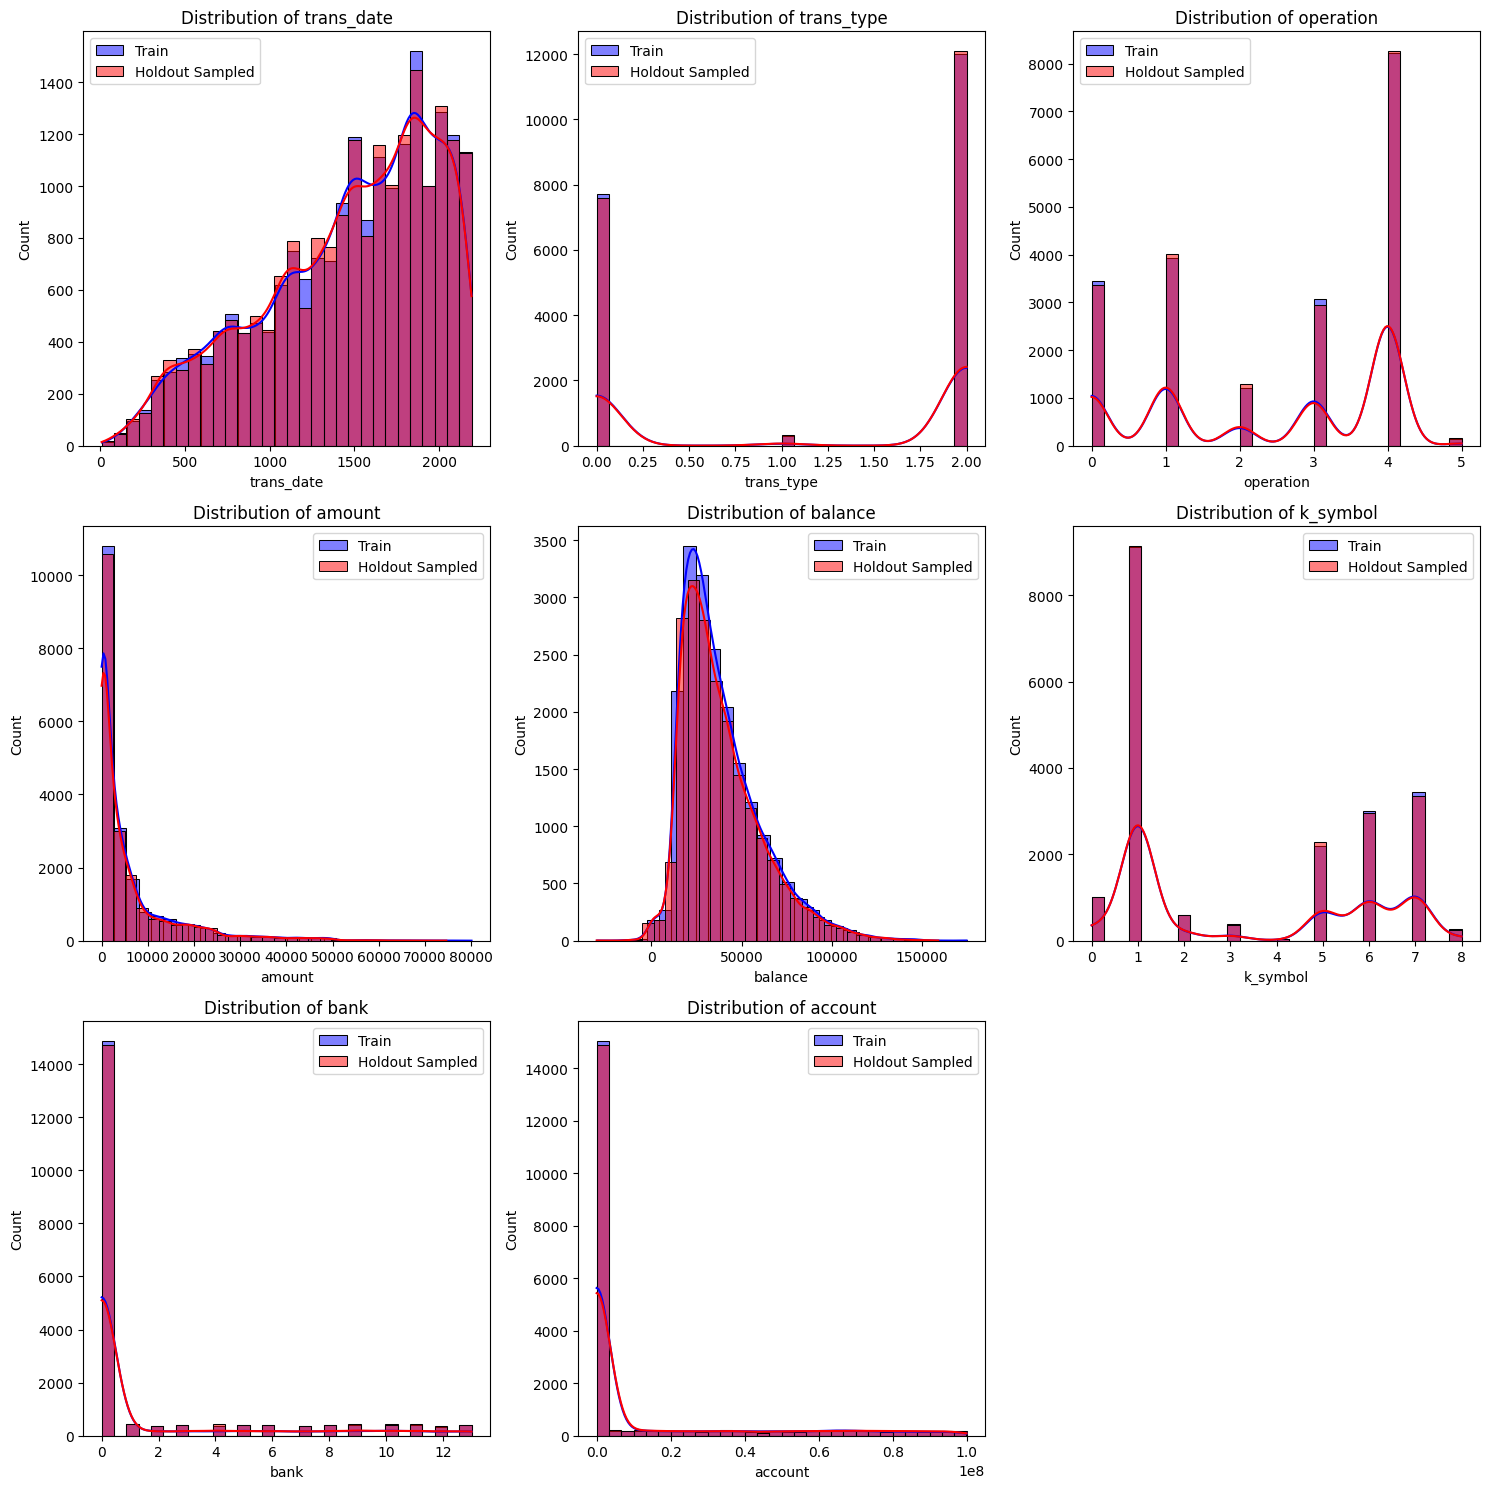

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
train = pd.read_csv("tabddpm_white_box/train/tabddpm_1/train_with_id.csv")
holdout = pd.read_csv("tabddpm_white_box/train/tabddpm_1/holdout_with_id.csv")

# Drop identifier columns
columns_to_plot = [col for col in train.columns if col not in ["trans_id", "account_id"]]

# Randomly sample holdout data to match train size
holdout_sampled = holdout.sample(n=len(train), random_state=42)

# Set up the figure and axes
num_cols = len(columns_to_plot)
fig, axes = plt.subplots(nrows=(num_cols + 2) // 3, ncols=3, figsize=(15, 5 * ((num_cols + 2) // 3)))

# Flatten axes in case of single-row subplots
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(columns_to_plot):
    sns.histplot(train[col], bins=30, color="blue", label="Train", alpha=0.5, kde=True, ax=axes[i])
    sns.histplot(holdout_sampled[col], bins=30, color="red", label="Holdout Sampled", alpha=0.5, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].legend()

# Remove unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [130]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy  # KL divergence function

# Drop identifier columns
columns_to_plot = [col for col in train.columns if col not in ["trans_id", "account_id"]]

# Randomly sample holdout data to match train size
holdout_sampled = holdout.sample(n=len(train), random_state=42)

# Dictionary to store KL divergences
kl_divergences = {}

# Compute KL divergence for each column
for col in columns_to_plot:
    # Compute histograms (30 bins)
    train_hist, bin_edges = np.histogram(train[col], bins=30, density=True)
    holdout_hist, _ = np.histogram(holdout_sampled[col], bins=30, density=True)

    # Avoid zero probabilities (add small constant)
    train_hist += 1e-10
    holdout_hist += 1e-10

    # Normalize to get probability distributions
    train_hist /= np.sum(train_hist)
    holdout_hist /= np.sum(holdout_hist)

    # Compute KL divergence
    kl_div = entropy(train_hist, holdout_hist)  # KL(train || holdout)
    kl_divergences[col] = kl_div

# Print results
for col, kl in kl_divergences.items():
    print(f"KL Divergence for {col}: {kl:.4f}")


KL Divergence for trans_date: 0.0019
KL Divergence for trans_type: 0.0002
KL Divergence for operation: 0.0003
KL Divergence for amount: 0.0056
KL Divergence for balance: 0.0701
KL Divergence for k_symbol: 0.0002
KL Divergence for bank: 0.0006
KL Divergence for account: 0.0012


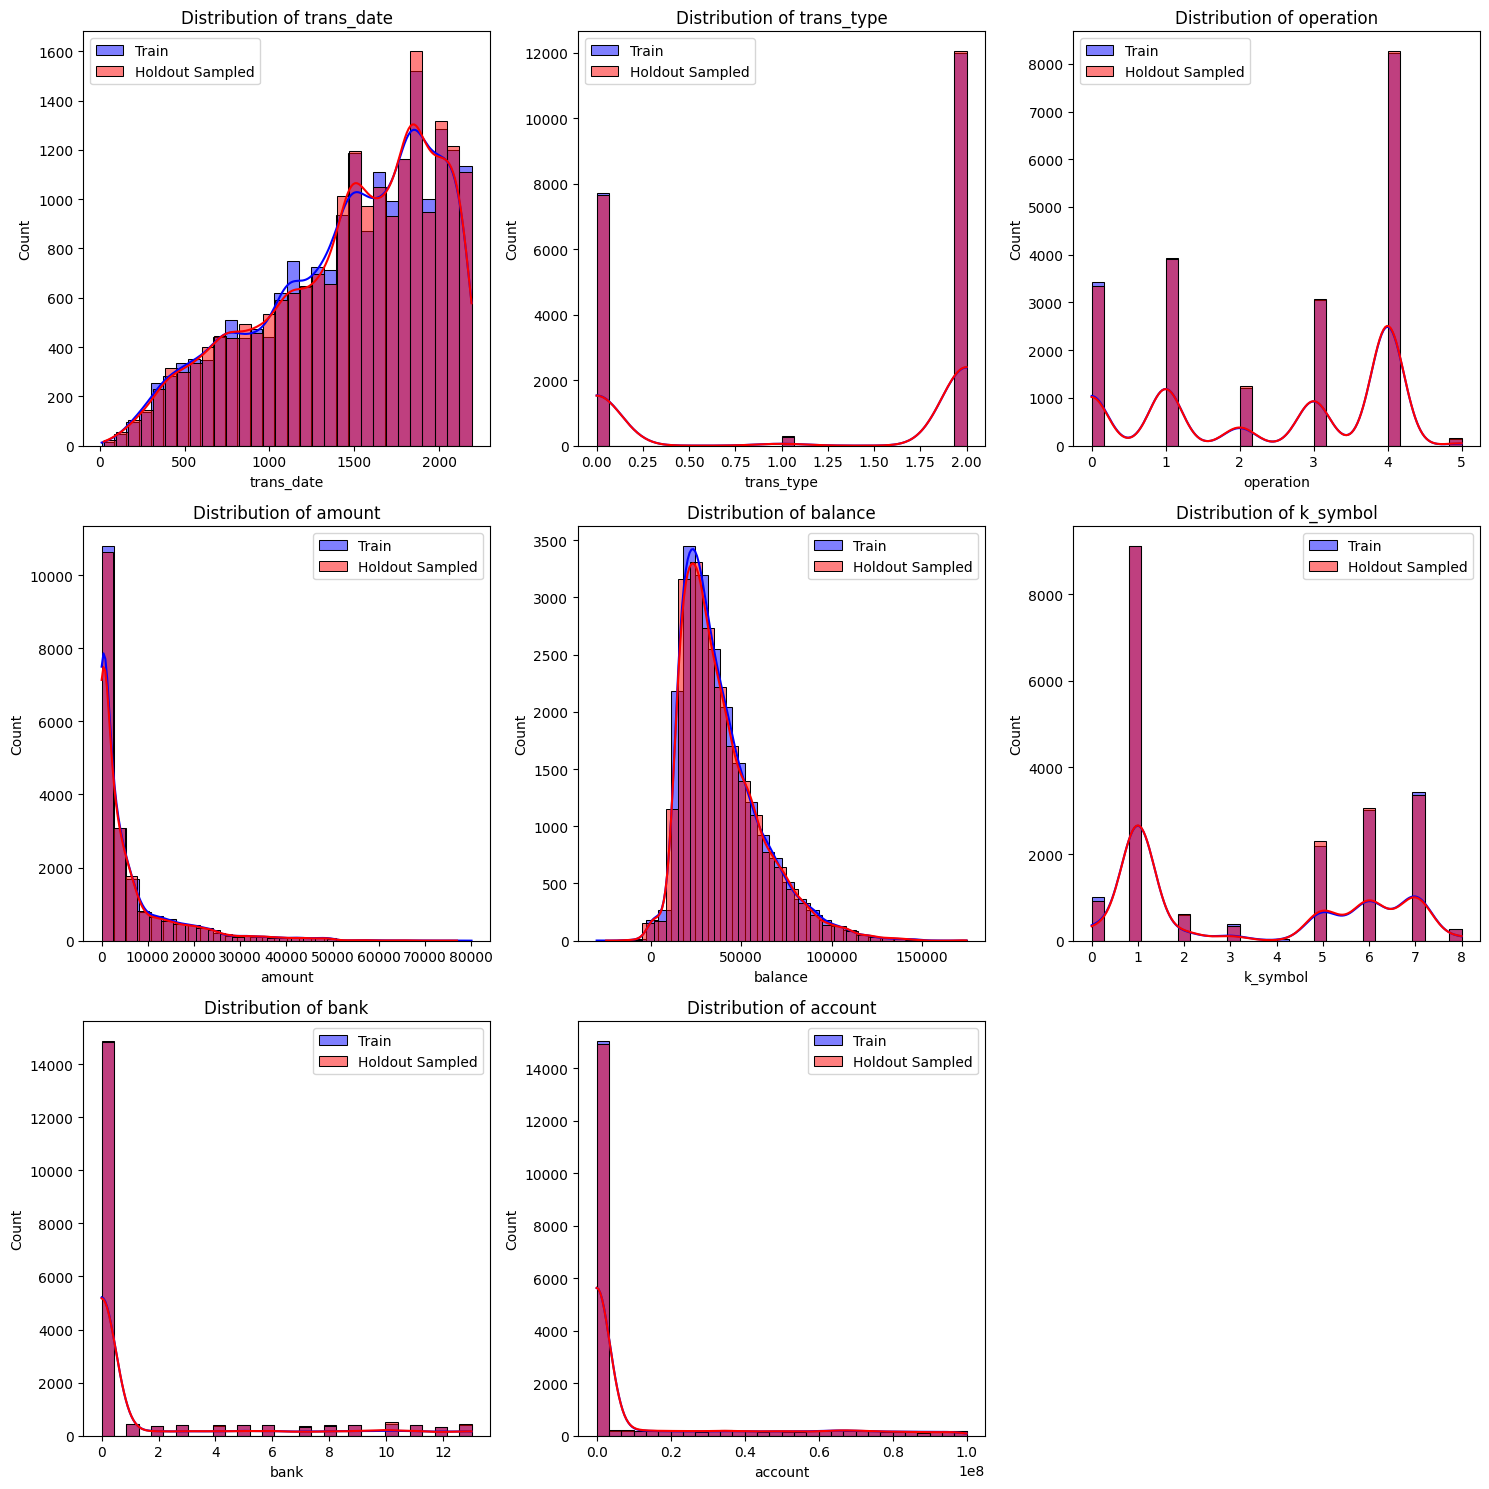

KL Divergence for trans_date: 0.0032
KL Divergence for trans_type: 0.0000
KL Divergence for operation: 0.0002
KL Divergence for amount: 0.0036
KL Divergence for balance: 0.0462
KL Divergence for k_symbol: 0.0021
KL Divergence for bank: 0.0005
KL Divergence for account: 0.0009


In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import numpy as np

# Load the datasets
train = pd.read_csv("tabddpm_white_box/train/tabddpm_1/train_with_id.csv")
holdout = pd.read_csv("tabddpm_white_box/train/tabddpm_1/trans_synthetic.csv")

# Drop identifier columns
columns_to_plot = [col for col in train.columns if col not in ["trans_id", "account_id"]]

# Randomly sample holdout data to match train size
holdout_sampled = holdout.sample(n=len(train), random_state=42)

# Set up the figure and axes
num_cols = len(columns_to_plot)
fig, axes = plt.subplots(nrows=(num_cols + 2) // 3, ncols=3, figsize=(15, 5 * ((num_cols + 2) // 3)))

# Flatten axes in case of single-row subplots
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(columns_to_plot):
    sns.histplot(train[col], bins=30, color="blue", label="Train", alpha=0.5, kde=True, ax=axes[i])
    sns.histplot(holdout_sampled[col], bins=30, color="red", label="Holdout Sampled", alpha=0.5, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].legend()

# Remove unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Dictionary to store KL divergences
kl_divergences = {}

# Compute KL divergence for each column
for col in columns_to_plot:
    # Compute histograms (30 bins)
    train_hist, bin_edges = np.histogram(train[col], bins=30, density=True)
    holdout_hist, _ = np.histogram(holdout_sampled[col], bins=30, density=True)

    # Avoid zero probabilities (add small constant)
    train_hist += 1e-10
    holdout_hist += 1e-10

    # Normalize to get probability distributions
    train_hist /= np.sum(train_hist)
    holdout_hist /= np.sum(holdout_hist)

    # Compute KL divergence
    kl_div = entropy(train_hist, holdout_hist)  # KL(train || holdout)
    kl_divergences[col] = kl_div

# Print results
for col, kl in kl_divergences.items():
    print(f"KL Divergence for {col}: {kl:.4f}")


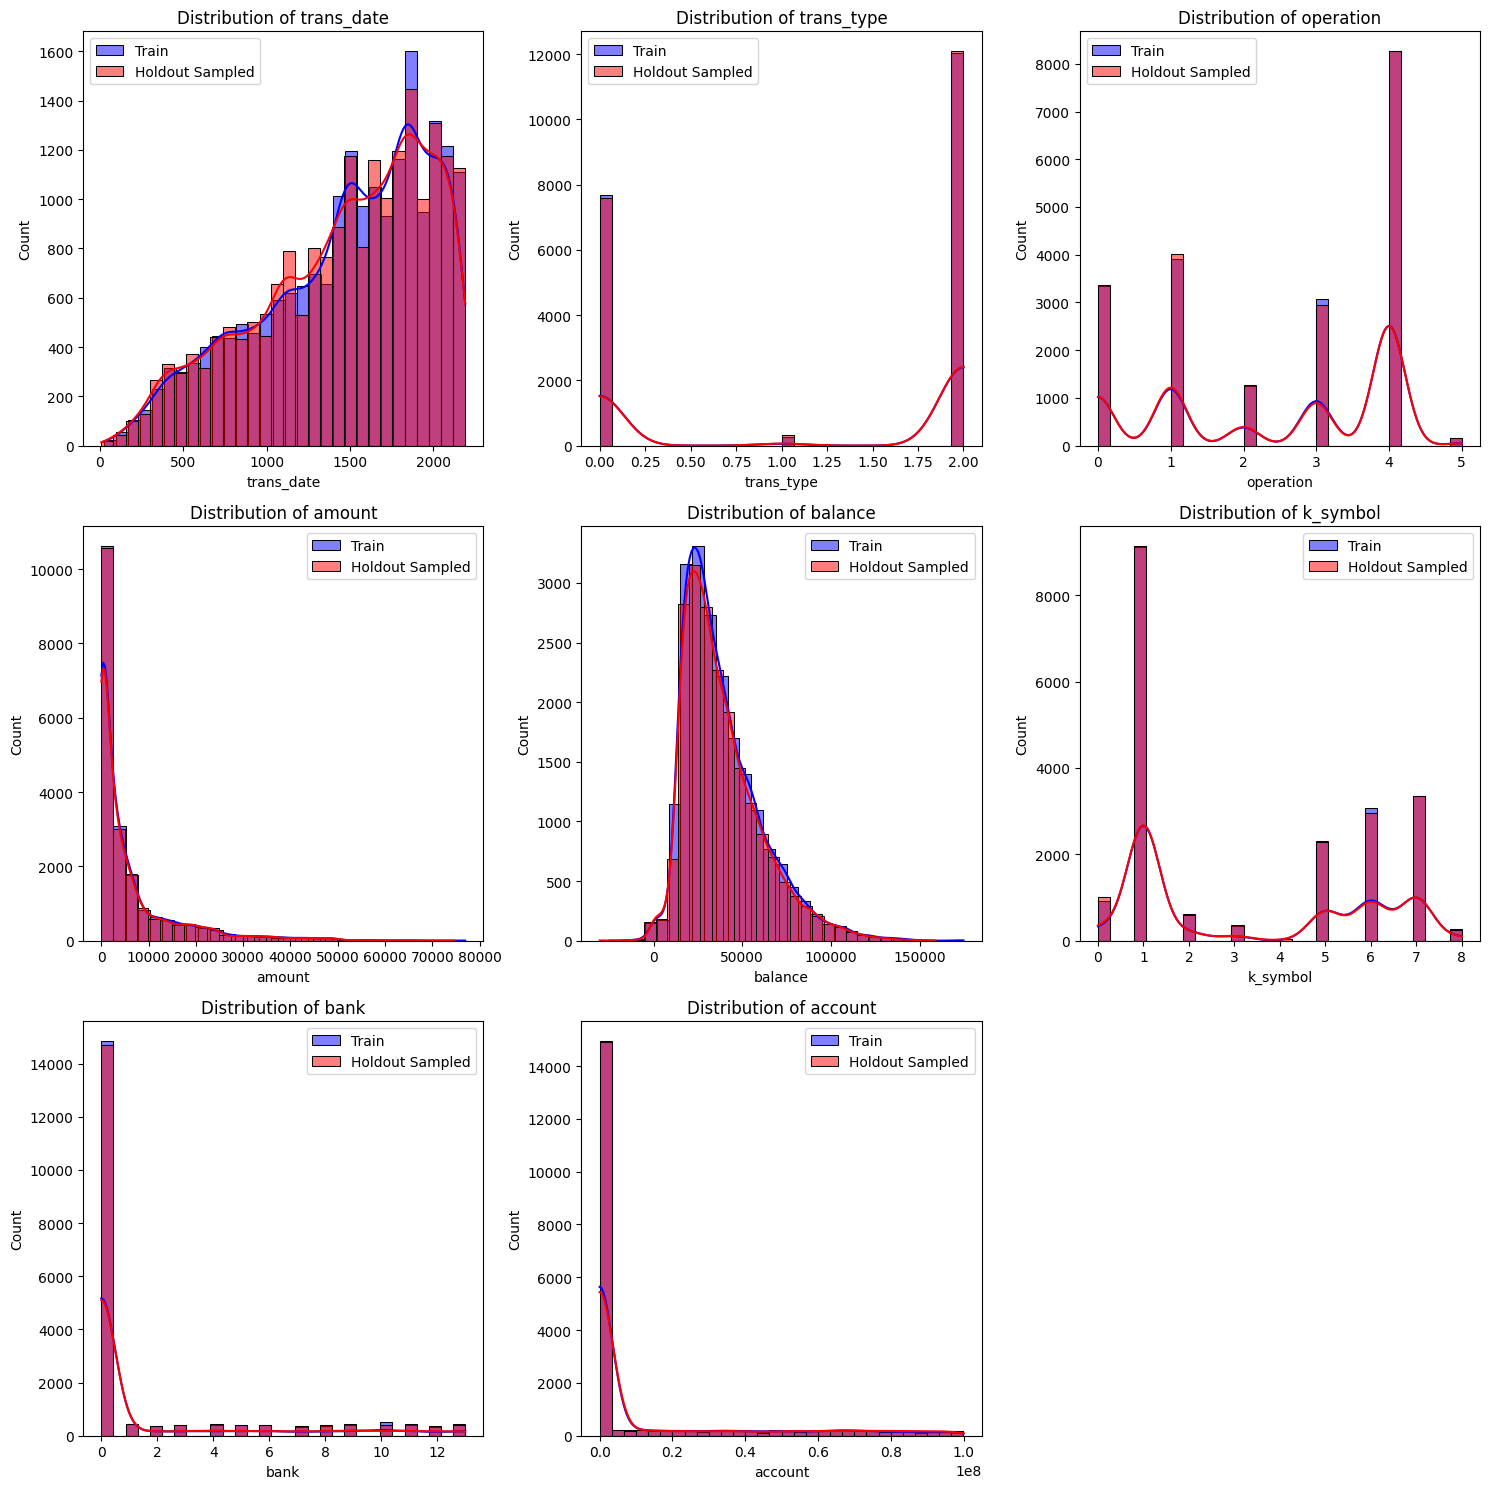

KL Divergence for trans_date: 0.0066
KL Divergence for trans_type: 0.0002
KL Divergence for operation: 0.0002
KL Divergence for amount: 0.0021
KL Divergence for balance: 0.2264
KL Divergence for k_symbol: 0.0013
KL Divergence for bank: 0.0013
KL Divergence for account: 0.0016


In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import numpy as np

# Load the datasets
holdout = pd.read_csv("tabddpm_white_box/train/tabddpm_1/holdout_with_id.csv")
train = pd.read_csv("tabddpm_white_box/train/tabddpm_1/trans_synthetic.csv")

# Drop identifier columns
columns_to_plot = [col for col in train.columns if col not in ["trans_id", "account_id"]]

# Randomly sample holdout data to match train size
holdout_sampled = holdout.sample(n=len(train), random_state=42)

# Set up the figure and axes
num_cols = len(columns_to_plot)
fig, axes = plt.subplots(nrows=(num_cols + 2) // 3, ncols=3, figsize=(15, 5 * ((num_cols + 2) // 3)))

# Flatten axes in case of single-row subplots
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(columns_to_plot):
    sns.histplot(train[col], bins=30, color="blue", label="Train", alpha=0.5, kde=True, ax=axes[i])
    sns.histplot(holdout_sampled[col], bins=30, color="red", label="Holdout Sampled", alpha=0.5, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].legend()

# Remove unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Dictionary to store KL divergences
kl_divergences = {}

# Compute KL divergence for each column
for col in columns_to_plot:
    # Compute histograms (30 bins)
    train_hist, bin_edges = np.histogram(train[col], bins=30, density=True)
    holdout_hist, _ = np.histogram(holdout_sampled[col], bins=30, density=True)

    # Avoid zero probabilities (add small constant)
    train_hist += 1e-10
    holdout_hist += 1e-10

    # Normalize to get probability distributions
    train_hist /= np.sum(train_hist)
    holdout_hist /= np.sum(holdout_hist)

    # Compute KL divergence
    kl_div = entropy(train_hist, holdout_hist)  # KL(train || holdout)
    kl_divergences[col] = kl_div

# Print results
for col, kl in kl_divergences.items():
    print(f"KL Divergence for {col}: {kl:.4f}")


In [75]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Load datasets
train = pd.read_csv("tabddpm_white_box/train/tabddpm_1/train_with_id.csv")
holdout = pd.read_csv("tabddpm_white_box/train/tabddpm_1/holdout_with_id.csv")
synthetic = pd.read_csv("tabddpm_white_box/train/tabddpm_1/trans_synthetic.csv")

# Drop ID columns
features = [col for col in train.columns if col not in ["trans_id", "account_id"]]

# Randomly sample holdout data to match train size
holdout_sampled = holdout.sample(n=len(train), random_state=42)

# Fit Kernel Density Estimation (KDE) on synthetic data
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(synthetic[features])

# Compute log-likelihoods for train and holdout
train_likelihood = kde.score_samples(train[features])
holdout_likelihood = kde.score_samples(holdout_sampled[features])

# Create dataset for classification
X = np.concatenate([train_likelihood, holdout_likelihood]).reshape(-1, 1)
y = np.array([0] * len(train) + [1] * len(holdout_sampled))  # 0=train, 1=holdout

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
# clf.fit(X_train, y_train)

from xgboost import XGBClassifier

clf = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC Score: {auc:.4f}")

ValueError: Found input variables with inconsistent numbers of samples: [8000, 32000]

In [79]:
from xgboost import XGBClassifier

clf = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC Score: {auc:.4f}")

ROC-AUC Score: 0.5053


In [80]:
y_pred = clf.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print(f"ROC-AUC Score: {auc:.4f}")

ROC-AUC Score: 0.6226


In [65]:
ls

README.md                    tabddpm_white_box/
__MACOSX/                    tabddpm_white_box.zip
__init__.py                  tabsyn_white_box/
__pycache__/                 tabsyn_white_box.zip
blackbox_multi_table.ipynb   wbst_gsa.ipynb
blackbox_single_table.ipynb  wbst_quantile_multitimestep.ipynb
data.py                      white_box_single_table_submission.zip
metrics.py                   whitebox_multi_table.ipynb
requirements.txt             whitebox_single_table.ipynb


In [66]:
pip install seaborn

    pandas (>=1.0.*)
            ~~~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
